<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Bartian/Big_Data_Milk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [2]:
# To initialize Apache Spark, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from google.colab import drive
drive.mount('/content/gdrive/')

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,365 kB]
Get:12 http://ppa.launchpad.net

Loading the data into a DF


In [3]:
#@title Default title text


milk_data = spark.read.csv('/content/gdrive/MyDrive/Big_Data_Groupwork/ff_dairy_v1.csv', header=True, inferSchema = True)
# work from dataframes is sufficient

In [6]:
!ls /content/gdrive/MyDrive

 20181122_150705.jpg  'BSc thesis contract periode 2 2018-2019 (1).gdoc'
 20181128_135701.jpg  'BSc thesis contract periode 2 2018-2019.gdoc'
 20181218_161948.jpg  'Colab Notebooks'
 20200806_163943.jpg  'Copy of 20181128_135701.jpg'
 20200806_163952.jpg   Muziek
 20200806_164020.jpg  'Presentation De Groene Bunker (1).pptx'
 20200806_164030.jpg  'RegSheet_LA&DM_per_group_CPE_blanc_2019 (1).gsheet'
 20200806_164100.jpg  'RegSheet_LA&DM_per_group_CPE_blanc_2019 (1).xlsx'
 20200806_164107.jpg  'RegSheet_LA&DM_per_group_CPE_blanc_2019 (2).gsheet'
 Arianna	      'RegSheet_LA&DM_per_group_CPE_blanc_2019 (2).xlsx'
 Bartian-world.zip    'RegSheet_LA&DM_per_group_CPE_blanc_2019.gsheet'
 Big_Data_Groupwork


In [8]:
milk_data.show(5)

+----------+-------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+---------------------+---------+---------------------+-------------------------+-------+-----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-------

Qusetion 1: 

Which combination of nutrients is the best predictor for the fat yield (milk yield * fat %) ?

In [4]:
# select the yield column and fat% column

yield_col = milk_data.select('Milk yield (kg)')
fat_pc_col = milk_data.select('Fat%')

yield_col.take(5)
yield_col.show(5)

yield_fat = map(lambda x, y : x*y, (yield_col, fat_pc_col))
# yield_fat.alias('Fat yield')



+---------------+
|Milk yield (kg)|
+---------------+
|          40.47|
|          38.29|
|          39.28|
|          38.16|
|          44.06|
+---------------+
only showing top 5 rows



In [10]:
# seletc the nutrient columns in g/day

# crude fiber, sugar, crude protein, crude fat, starch, Ca, P, Na, Cl, K, Mg, WDS, SPK, TPK, SPE, TPE, +I, Wi, GP 
# intestines: nXP, RNB, MELK, NEL, WDE, EKB

cr_fiber_col = milk_data.select('Crude fiber (g/day)')
sugar_col = milk_data.select('Sugar (g/day)')
cr_protein_col = milk_data.select('Crude protein (g/day)')
cr_fat_col = milk_data.select('Crude fat (g/day)')
starch_col = milk_data.select('Starch (g/day)')

ca_col = milk_data.select('Ca (g/day)')
p_col = milk_data.select('P (g/day)')
na_col = milk_data.select('Na (g/day)')
cl_col = milk_data.select('Cl (g/day)')
k_col = milk_data.select('K (g/day)')
mg_col = milk_data.select('Mg (g/day)')



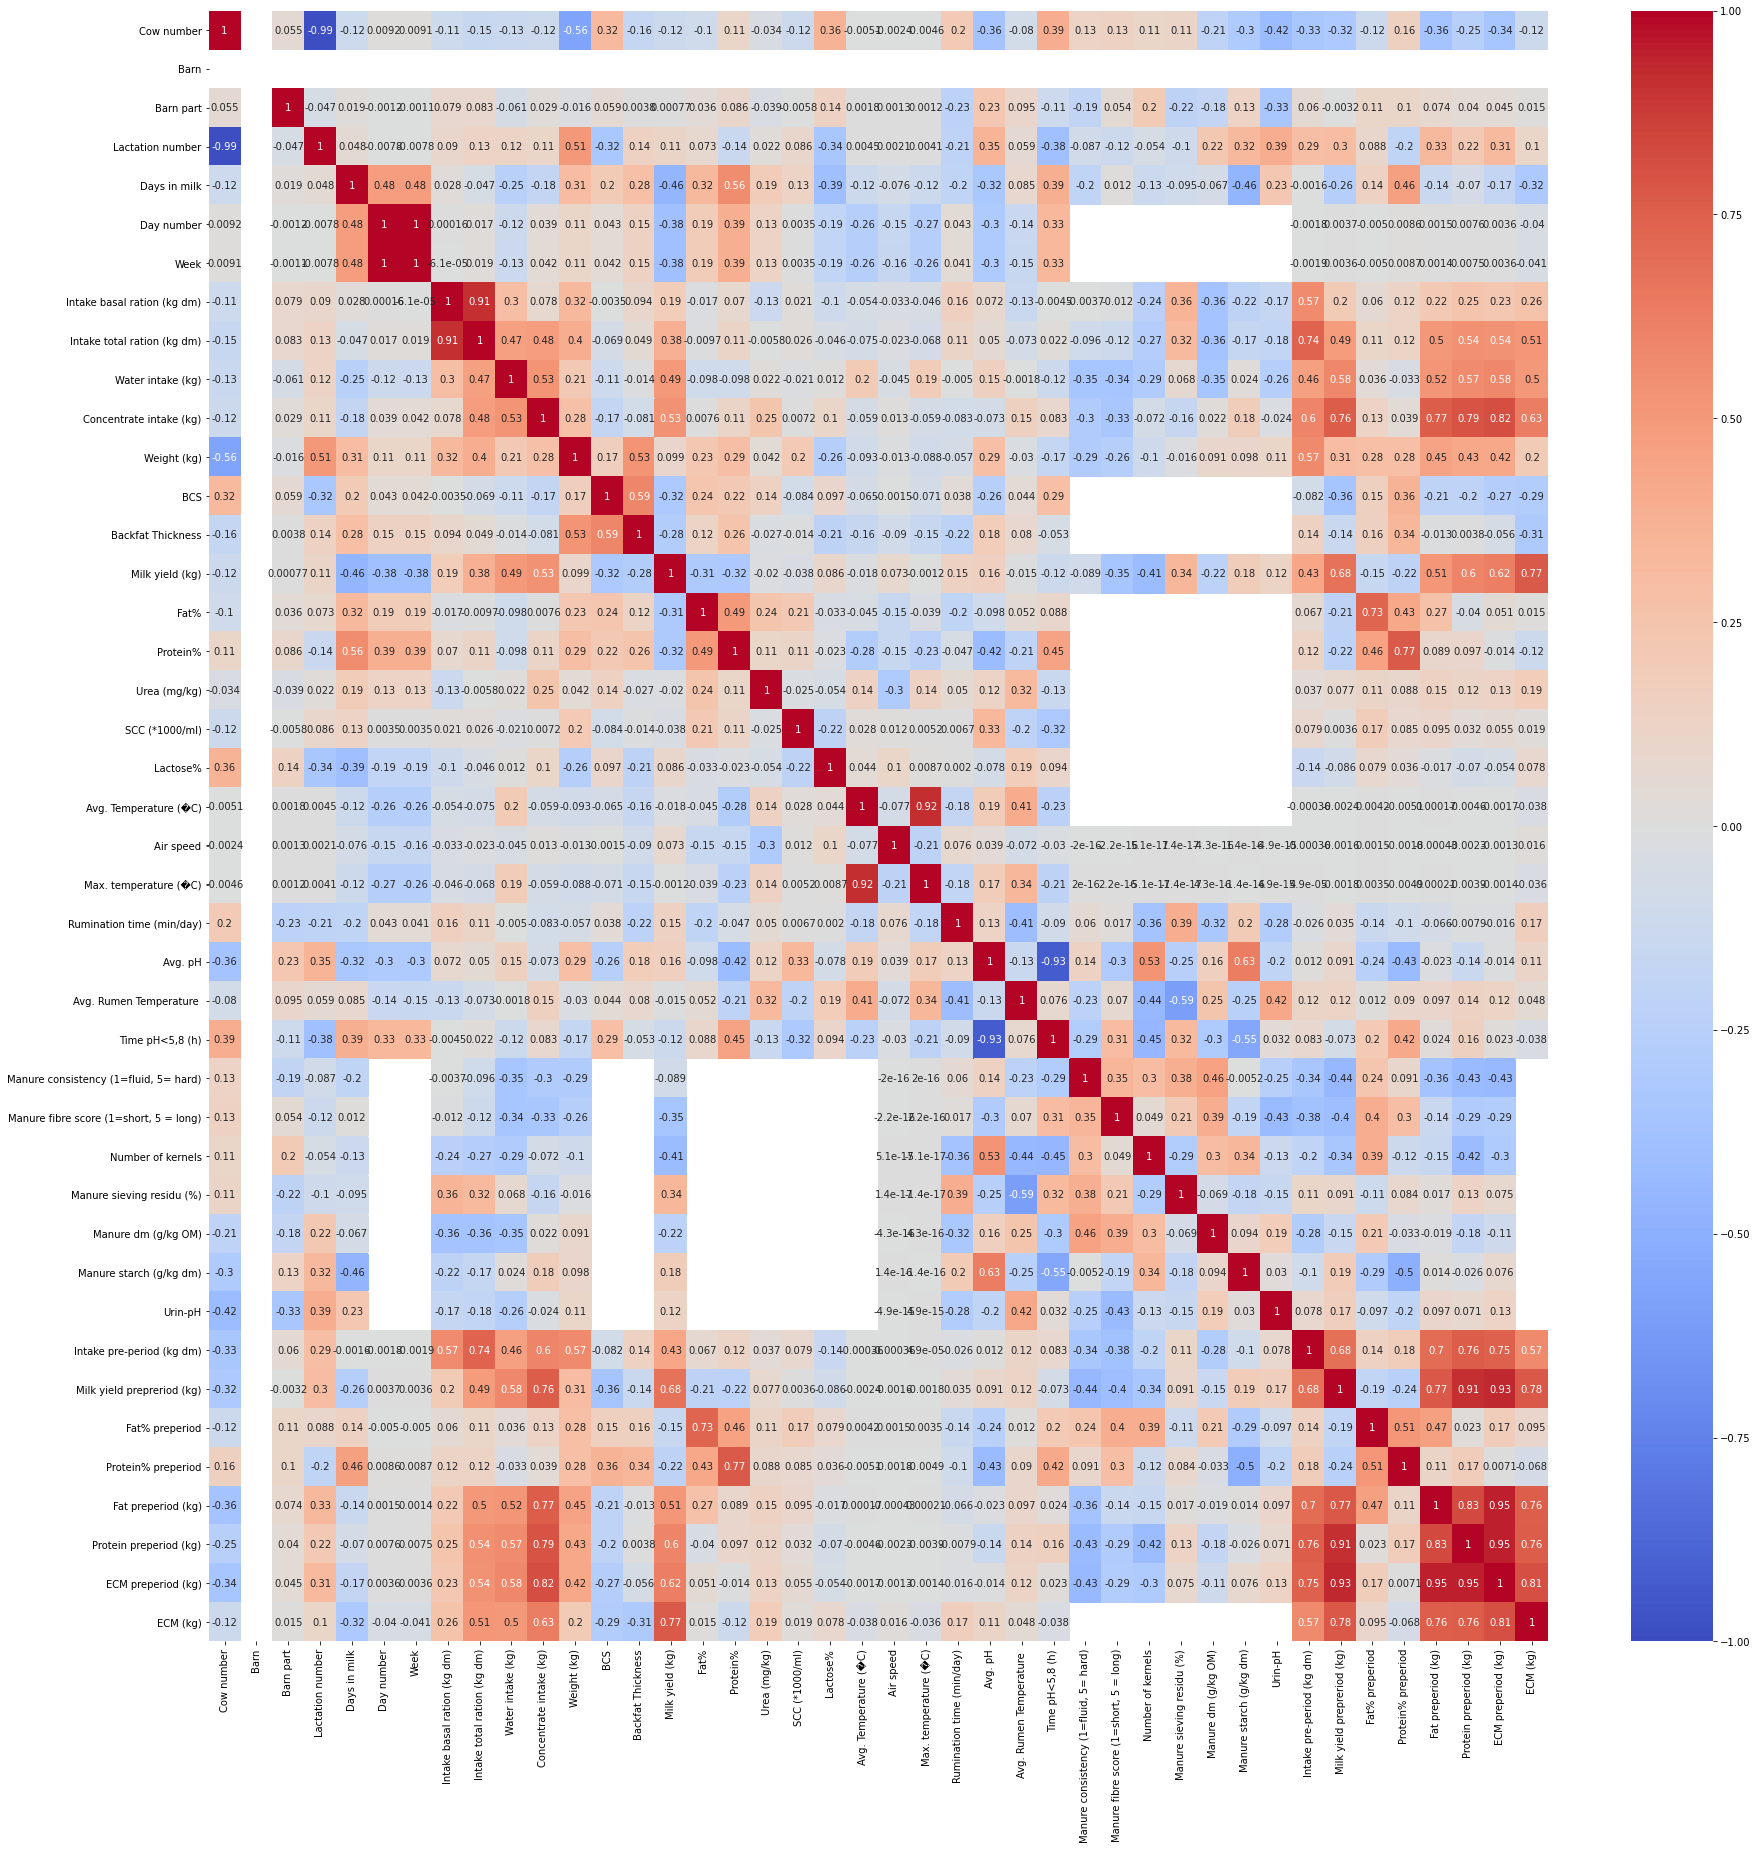

In [9]:
# create linear regression models 

import seaborn as sns 
import pandas as pd
from matplotlib import pyplot as plt

data_pd = milk_data.select('*').toPandas()

corr_mat = data_pd.corr(method='pearson')
plt.subplots(figsize=(30,30))
sns.heatmap(corr_mat[], cmap='coolwarm', vmin=-1,vmax=1, annot=True)